In [1]:
from data_utils import *
from model_utils import *
from train_utils import *
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [2]:
print(f"Data Path being used: {DATA_PATH}")
dataset = load_dataset_for_lstm()
classes = dataset.classes

train_dataset, val_dataset = split_dataset(dataset, val_ratio=0.2, random_seed=42)
train_loader, val_loader = get_loaders(train_dataset, val_dataset, batch_size=32)

print(f"Aantal classes: {len(classes)}")
print(f"Classes: {classes}")
print(f"Training sequences: {len(train_dataset)}")
print(f"Validation sequences: {len(val_dataset)}")


Data Path being used: c:\Studies\Smartglass Project\SmartGlasses\notebooks\package\smart_gestures\gestures\lstm_model\dataset
Found 5 gestures: ['goed', 'hallo', 'ja', 'nee', 'tot_ziens']
Aantal classes: 5
Classes: ['goed', 'hallo', 'ja', 'nee', 'tot_ziens']
Training sequences: 117
Validation sequences: 29


In [3]:
in_dim = 258
num_classes = len(classes)
HIDDEN_SIZE = 128
NUM_LAYERS = 2
SEQUENCE_LENGTH_REF = SEQUENCE_LENGTH # Add for reference

model = create_model(num_classes, in_dim, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)

try:
    model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'lstm_model.pth'), map_location=DEVICE))
    print("Model weights loaded successfully.")
except FileNotFoundError:
    print("No pre-trained weights found. Starting from scratch.")

No pre-trained weights found. Starting from scratch.


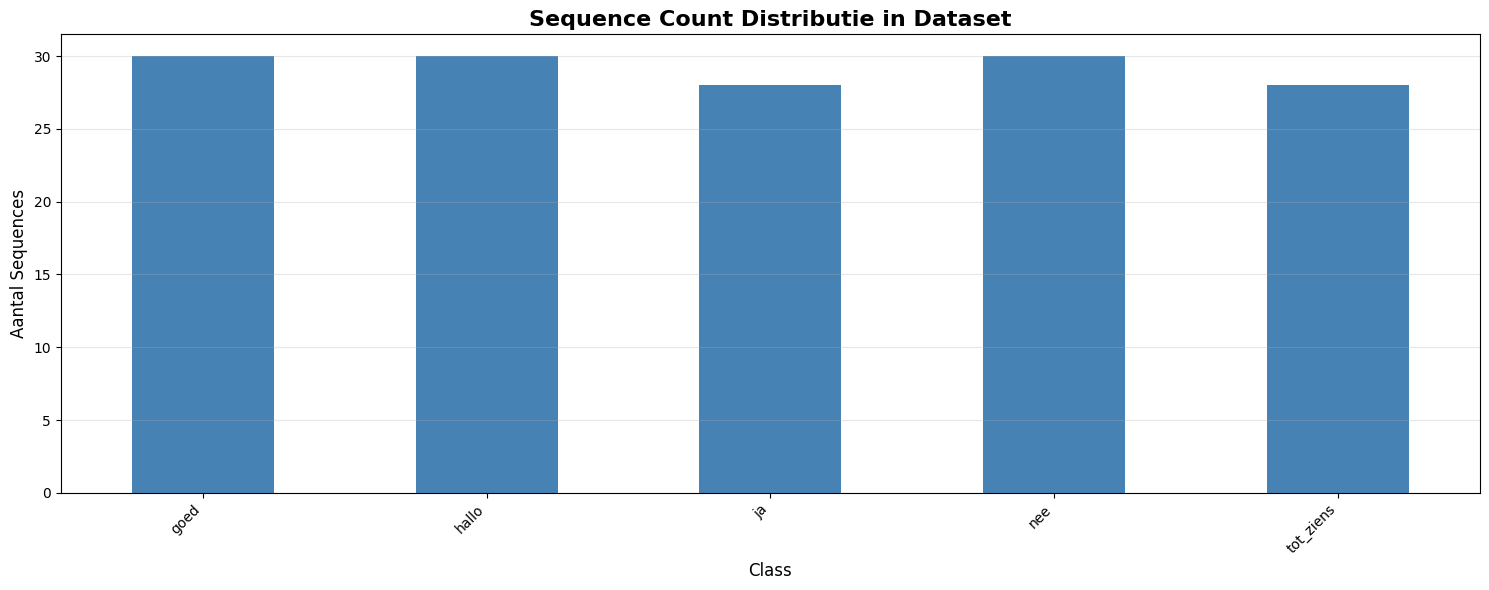


Totaal aantal sequences: 146
Gemiddeld aantal sequences per class: 29.2
Min sequences: 28, Max sequences: 30


In [8]:
label_counts = {}
for idx in dataset.y:
    gesture_name = dataset.classes[idx]
    label_counts[gesture_name] = label_counts.get(gesture_name, 0) + 1

class_counts = pd.Series(label_counts).sort_index()

plt.figure(figsize=(15, 6))
class_counts.plot(kind='bar', color='steelblue')
plt.title('Sequence Count Distributie in Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Aantal Sequences', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTotaal aantal sequences: {len(dataset)}")
print(f"Gemiddeld aantal sequences per class: {class_counts.mean():.1f}")
print(f"Min sequences: {class_counts.min()}, Max sequences: {class_counts.max()}")

In [9]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels, lengths in val_loader:
        
        inputs = inputs.to(DEVICE)
        
        # Call the model with inputs and lengths (as defined in the corrected model_utils.py)
        outputs = model(inputs, lengths) 
        
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = 100 * (all_preds == all_labels).sum() / len(all_labels)
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Accuracy: 20.69%
